In [41]:
import numpy as np
import sympy as sm
from scipy import optimize
from scipy import interpolate
from scipy.optimize import minimize
import statistics as stat

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Linear regression

Consider the following **linear equation:**

$$y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \epsilon_i$$

Assume you have access to data of the **independent variables** ($x_{1,i}$, $x_{2,i}$) and the **dependent variable** ($y_i$) for $N$ individuals, where $i$ indexes individuals. The variable $\epsilon_i$ is a mean-zero **stochastic shock**.

Assume the **data generating process** is given by:

In [42]:
def DGP(N):
    # a. independent variables
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    
    # b. errors
    eps = np.random.normal(0,1,size=N)
    
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    
    # c. dependent variable
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    return x1, x2, y

**The data you have access to is:**

In [43]:
np.random.seed(2020)
x1,x2,y = DGP(10000)

**Question 1:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **ordinary least squares (OLS)** implemented with **matrix algebra** by

$$ \hat{\mathbf{\beta}} = (\mathbf{X}^{\prime}\mathbf{X})^{-1}\mathbf{X}^{\prime}\mathbf{y} $$

where $\mathbf{X}^{\prime}$ is the transpose of $\mathbf{X}$ and

$$\mathbf{y} = 
\pmatrix{ y_1 \cr y_2 \cr  \vdots \cr y_N 
}
, \quad \mathbf{X} = \pmatrix{
1 & x_{1,1} & x_{2,1} \cr 
1 & x_{1,2} & x_{2,2} \cr 
\vdots & \vdots \cr 
1 & x_{1,N} & x_{2,N} 
}$$

In [44]:
#Choose the amount of observations
N=10000

#Define the transposed y-matrix
YT = np.array([y])

#Transpose it to make it vertical
Y = YT.T

#Make the X-matrix
X = np.column_stack((np.ones(N),x1,x2))

#Transpose X-matrix
XT = X.T


In [45]:
#Calculating beta_hat
beta_hat = np.linalg.inv(XT@X)@XT@Y

#Define each estimate
beta_hat0 = beta_hat[0,0]
beta_hat1 = beta_hat[1,0]
beta_hat2 = beta_hat[2,0]

print(f'With matrix algebra: beta_hat0 = {beta_hat0:.4f}, beta_hat1 = {beta_hat1:.4f}, beta_hat2 = {beta_hat2:.4f}')

With matrix algebra: beta_hat0 = 0.0957, beta_hat1 = 0.2929, beta_hat2 = 0.5033


**Question 2:** Construct a 3D plot, where the data is plotted as scattered points, and the prediction of the model is given by the plane

$$\hat{y}_i = \hat{\beta}_0 + \hat{\beta}_1 x_{1,i} + \hat{\beta}_2 x_{2,i}$$

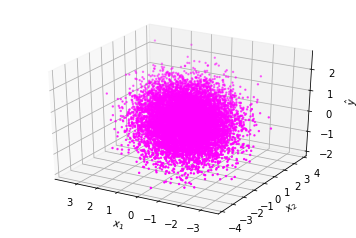

In [46]:
#We find the estimated value of y
yhat = beta_hat0 + beta_hat1*x1 + beta_hat2*x2

#Create the plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.scatter(x1,x2,yhat,s=2,color='magenta')

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$\hat{y}$')

ax.invert_xaxis()

plt.show()

**Question 3:** Esimtate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using a **numerical solver** to solve the ordinary least square problem, shown below, directly. Compare your results with the matrix algebra results.

$$ \min_{\mathbf{\beta}} \sum^N_{i=1} (y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) )^2 $$

In [47]:
#Solve OLS numerically
ols=np.linalg.lstsq(X, Y, rcond=None)[0]
print(f'With numerical solver: beta_hat0 = {ols[0,0]:.4f}, beta_hat1 = {ols[1,0]:.4f}, beta_hat2 = {ols[2,0]:.4f}')

With numerical solver: beta_hat0 = 0.0957, beta_hat1 = 0.2929, beta_hat2 = 0.5033


The matrix algebra and the numerical solver yields the same estimates of the beta values.

**Question 4:** Estimate the vector of coefficients $\mathbf{\beta} = (\beta_0,\beta_1,\beta_2)$ using **least absolute deviations (LAD)** using a numerical solver to solve the following problem directly: 

$$  \min_{\beta} \sum^N_{i=1} |y_i - (\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i}) | $$

where $|z|$ is the absolute value of $z$.

In [48]:
def lad_func(b,x1,x2,y):
    """
    Args:
        b (array)  : An array containing our beta parameters
        x1 (array) : Array containing our x1-values
        x2 (array) : Array containing our x2-values
        y (array)  : Array containing our y-values
    
    Returns:
        The function containing LAD-values
    """
    beta0 = b[0]
    beta1 = b[1]
    beta2 = b[2]
    return np.sum(np.abs(y-(beta0+beta1*x1+beta2*x2)))

#We minimize the LAD function
output = minimize(lad_func,ols,args=(x1,x2,y))

print(f'With LAD: beta_hat0 = {output.x[0]:.4f}, beta_hat1 = {output.x[1]:.4f}, beta_hat2 = {output.x[2]:.4f}')

With LAD: beta_hat0 = 0.0922, beta_hat1 = 0.3074, beta_hat2 = 0.5115


**Question 5:** Set $N = 50$. Repeat the estimation using the **OLS** and **LAD** methods $K=5000$ times, drawing a new random sample from the data generating process each time. Compare the estimates from each method using histograms. Which method do you prefer? Explain your choice.

In [49]:
N=50

#Define emty lists to contain beta values for LAD-method
beta_0_lad = []
beta_1_lad = []
beta_2_lad = []
    
for K in range(5000):
    
    #The variables are redefined to loop over
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    eps = np.random.normal(0,1,size=N)
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    #Minimize LAD-function
    output = minimize(lad_func,ols,args=(x1,x2,y))
    
    #Collect beta-values
    beta_0_lad.append(output.x[0])
    beta_1_lad.append(output.x[1])
    beta_2_lad.append(output.x[2])


/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1046: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


In [50]:
#Define emty lists to contain beta values for OLS-method
beta_0_ols = []
beta_1_ols = []
beta_2_ols = []

for K in range(5000):
    #The variables are redefined to loop over
    x1 = np.random.normal(0,1,size=N)
    x2 = np.random.normal(0,1,size=N)
    eps = np.random.normal(0,1,size=N)
    extreme = np.random.uniform(0,1,size=N)
    eps[extreme < 0.05] += np.random.normal(-5,1,size=N)[extreme < 0.05]
    eps[extreme > 0.95] += np.random.normal(5,1,size=N)[extreme > 0.95]
    y = 0.1 + 0.3*x1 + 0.5*x2 + eps
    
    #Re-make the X-matrix
    X = np.column_stack((np.ones(N),x1,x2))

    #Re-define the transposed y-matrix
    YT = np.array([y])
    
    #Transpose it to make it vertical
    Y = YT.T
    
    
    ols=np.linalg.lstsq(X, Y, rcond=None)[0]
    
    #Collect beta-values
    beta_0_ols.append(ols[0,0])
    beta_1_ols.append(ols[1,0])
    beta_2_ols.append(ols[2,0])

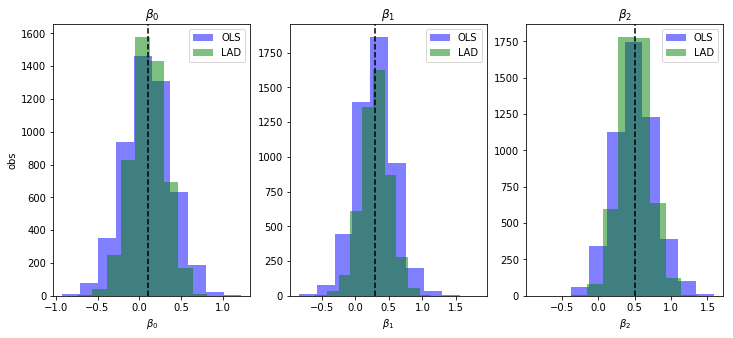

In [51]:
#Create the plots 
figb = plt.figure(figsize=(12,5))

#The plot for beta0
ax_left = figb.add_subplot(1,3,1)
ax_left.hist(beta_0_ols,alpha=0.5,color='blue',label='OLS')
ax_left.hist(beta_0_lad,alpha=0.5,color='green',label='LAD')
plt.axvline(0.1,color='black',linestyle='--') #true value
ax_left.set_title(r'$\beta_0$')
ax_left.set_xlabel(r'$\beta_0$')
ax_left.set_ylabel('obs')
ax_left.legend(loc='upper right');

#The plot for beta1
ax_middle = figb.add_subplot(1,3,2)
ax_middle.hist(beta_1_ols,alpha=0.5,color='blue',label='OLS')
ax_middle.hist(beta_1_lad,alpha=0.5,color='green',label='LAD')
plt.axvline(0.3,color='black',linestyle='--') #true value
ax_middle.set_title(r'$\beta_1$')
ax_middle.set_xlabel(r'$\beta_1$')
ax_middle.legend(loc='upper right');

#The plot for beta2
ax_right = figb.add_subplot(1,3,3)
ax_right.hist(beta_2_ols,alpha=0.5,color='blue',label='OLS')
ax_right.hist(beta_2_lad,alpha=0.5,color='green',label='LAD')
plt.axvline(0.5,color='black',linestyle='--') #true value
ax_right.set_title(r'$\beta_2$')
ax_right.set_xlabel(r'$\beta_2$')
ax_right.legend(loc='upper right');

plt.show()

We investigates the properties of the LAD- and OLS-estimates:

In [52]:
print(f'Mean of beta_0 using LAD is {stat.mean(beta_0_lad):.4f}, standard deviation is {stat.stdev(beta_0_lad):.4f}')
print(f'Mean of beta_0 using OLS is {stat.mean(beta_0_ols):.4f}, standard deviation is {stat.stdev(beta_0_ols):.4f}')
print(' ')
print(f'Mean of beta_1 using LAD is {stat.mean(beta_1_lad):.4f}, standard deviation is {stat.stdev(beta_1_lad):.4f}')
print(f'Mean of beta_1 using OLS is {stat.mean(beta_1_ols):.4f}, standard deviation is {stat.stdev(beta_1_ols):.4f}')
print(' ')
print(f'Mean of beta_2 using LAD is {stat.mean(beta_2_lad):.4f}, standard deviation is {stat.stdev(beta_2_lad):.4f}')
print(f'Mean of beta_2 using OLS is {stat.mean(beta_2_ols):.4f}, standard deviation is {stat.stdev(beta_2_ols):.4f}')

Mean of beta_0 using LAD is 0.1029, standard deviation is 0.2034
Mean of beta_0 using OLS is 0.0986, standard deviation is 0.2806
 
Mean of beta_1 using LAD is 0.3029, standard deviation is 0.2118
Mean of beta_1 using OLS is 0.3003, standard deviation is 0.2851
 
Mean of beta_2 using LAD is 0.5008, standard deviation is 0.2099
Mean of beta_2 using OLS is 0.5025, standard deviation is 0.2817


Generally, the LAD-estimates have smaller standard deviations. This might be caused by the LAD-method giving less weight to outliers. Overall, it's hard to tell which estimation gives the most accurate results. LAD is generally more preferable if the distribution suffer from high kurtosis and skewness, which does not appear in this case. However, since the standard deviations seem to be smaller and the estimates does not seem to be significantly different from the true values for the LAD-method, we consider this to be preferable.

# Durable purchases

Consider a **household** living in two periods.

In the **second period** it gets utility from **non-durable consumption**, $c$, and **durable consumption**, $d+\chi x$:

$$
\begin{aligned}
v_{2}(m_{2},d)&= \max_{c}\frac{(c^{\alpha}(d+\chi x)^{1-\alpha})^{1-\rho}}{1-\rho}\\
\text{s.t.} \\
x &= m_{2}-c \\
c &\in [0,m_{2}]
\end{aligned}
$$

where 

* $m_2$ is cash-on-hand in the beginning of period 2
* $c$ is non-durable consumption
* $d$ is pre-commited durable consumption
* $x = m_2 - c$ is extra durable consumption
* $\rho > 1$ is the risk aversion coefficient
* $\alpha \in (0,1)$ is the utility weight on non-durable consumption
* $\chi \in (0,1)$ implies that extra durable consumption is *less* valuable than pre-comitted durable consumption
* the second constraint ensures the household *cannot* die in debt

The **value function** $v_2(m_2,d)$ measures the household's value of having $m_2$ at the beginning of period 2 with precomitted durable consumption of $d$. The optimal choice of non-durable consumption is denoted $c^{\ast}(m_2,d)$. The optimal extra durable consumption function is $x^{\ast}(m_2,d) = m_2-c^{\ast}(m_2,d)$.

Define the so-called **end-of-period 1 value function** as:

$$
\begin{aligned}
w(a,d)&\equiv\beta\mathbb{E}_{1}\left[v_2(m_2,d)\right]
\end{aligned}
$$

where 

$$
\begin{aligned}
m_2&= (1+r)a+y \\
y &= \begin{cases}
1-\Delta & \text{with prob. }\frac{1}{3}\\
1 & \text{with prob. }\frac{1}{3}\\
1+\Delta & \text{with prob. }\frac{1}{3}
\end{cases}\\
\end{aligned}
$$

and

* $a$ is assets at the end of period 1
* $\beta > 0$ is the discount factor
* $\mathbb{E}_1$ is the expectation operator conditional on information in period 1
* $y$ is income in period 2
* $\Delta \in (0,1)$ is the level of income risk (mean-preserving)
* $r$ is the return on savings

In the **first period**, the household chooses it's pre-comitted level of durable consumption for the next-period,

$$
\begin{aligned}
v_{1}(m_{1})&=\max_{d} w(a,d)\\&\text{s.t.}&\\
a&= m_{1}-d \\
d&\in [0,m_{1}]\\
\end{aligned}
$$

where $m_1$ is cash-on-hand in period 1. The second constraint ensures the household *cannot* borrow. The **value function** $v_1(m_1)$ measures the household's value of having $m_1$ at the beginning of period 1. The optimal choice of pre-committed durable consumption is denoted $d^{\ast}(m_1)$.

The **parameters** and **grids** for $m_1$, $m_2$ and $d$ should be:

In [53]:
# a. parameters
rho = 2
alpha = 0.8
beta = 0.96
r = 0.04
Delta = 0.25
chi = 0.9

# b. grids
m1_vec = np.linspace(1e-8,10,100)
m2_vec = np.linspace(1e-8,10,100)
d_vec = np.linspace(1e-8,5,100)

**Question 1:** Find and plot the functions $v_{2}(m_{2},d)$, $c^{\ast}(m_2,d)$, and $x^{\ast}(m_2,d)$. Comment.

Note that the code in this question is based on code from problem set 7, problem 4

In [54]:
#We define the value function for period 2
def v2(c,m2,d,alpha,chi,rho):
    """
    Args:
        c (float)     : non-durable consumption
        m2 (float)    : cash-on-hand in period 2
        d (float)     : pre-comitted durable consumption
        alpha (float) : utility weight on non-durable consumption
        chi (float)   : implies that extra durable consumption is less valuable than precomitted consumption
        rho (int)     : risk aversion coefficient
    
    Returns:
        Household's value of having m2 at the beginning of period 2
    """
    return ((c**alpha*(d+chi*(m2-c))**(1-alpha))**(1-rho))/(1-rho)


In [55]:
#solve second period
def solve_p2(alpha,chi,rho):
    """
    Args:
        alpha (float) : utility weight on non-durable consumption
        chi (float)   : implies that extra durable consumption is less valuable than precomitted consumption
        rho (int)     : risk aversion coefficient
    
    Returns:
        Value optimising vectors of c, x and the function values v2 corresponding to the values of m2_vec and d_vec
    """
    #grids
    v2_grid = np.empty((100,100))
    c_grid = np.empty((100,100))
    x_grid = np.empty((100,100))
    
    #solve for each m2 in grid
    for i,m2 in enumerate(m2_vec):
        for j,d in enumerate(d_vec):
        
            #objective
            obj=lambda c: -v2(c,m2,d,alpha,chi,rho)
        
            #initial guess
            x0=m2/2
        
            #optimizer
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])
            
            #collect results
            v2_grid[i,j] = -result.fun
            c_grid[i,j] = result.x
            x_grid[i,j] = m2 - result.x
        
    return m2_vec, d_vec, v2_grid, c_grid, x_grid
    

#Solve the problem
m2_vec, d_vec, v2_grid, c_grid, x_grid = solve_p2(alpha,chi,rho)


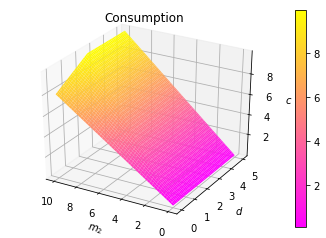

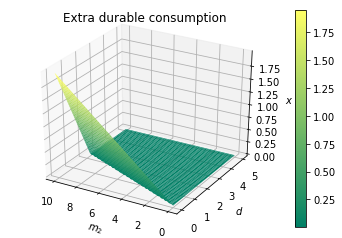

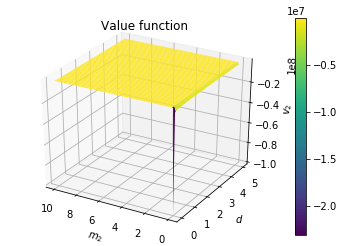

In [56]:
#Create grids
m2_grid,d_grid = np.meshgrid(m2_vec,d_vec,indexing='ij')

#Create the m2-d-c plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
cs = ax.plot_surface(m2_grid,d_grid,c_grid, cmap=cm.spring)

ax.set_xlabel('$m_2$')
ax.set_ylabel('$d$')
ax.set_zlabel('$c$')

ax.invert_xaxis()
ax.set_title('Consumption')

fig.colorbar(cs);


#Create the m2-d-x plot
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1,projection='3d')
xs = ax1.plot_surface(m2_grid,d_grid,x_grid, cmap=cm.summer)

ax1.set_xlabel('$m_2$')
ax1.set_ylabel('$d$')
ax1.set_zlabel('$x$')

ax1.invert_xaxis()
ax1.set_title('Extra durable consumption')

fig1.colorbar(xs);

#Create the m2-d-v2 plot
fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1,projection='3d')
vs = ax2.plot_surface(m2_grid,d_grid,v2_grid, cmap=cm.viridis)

ax2.set_xlabel('$m_2$')
ax2.set_ylabel('$d$')
ax2.set_zlabel('$v_2$')

ax2.invert_xaxis()
ax2.set_title('Value function')

fig2.colorbar(vs);

The first plot shows how non-durable consumption depends on cash-on-hand in period 2 and the pre-comitted durable consumption. It appears that the non-durable consumption depends positively on both m2 and d, and the slope is especially steep for values of d below a certain point.

The second plot shows how extra durable consumption depends on cash-on-hand in period 2 and the pre-comitted durable consumption. For most combinations of d and m2 there is no extra consumption. However, when either m2 is very large or d is very low (or somewhere in between) it results in extra durable consumption.

The third plot shows how the value in period 2 depends on cash-on-hand in period 2 and the pre-comitted durable consumption. From the plot it appears that v2 remains unchanged for all values excepts for one very low value. We suspect, however, that the graph does not portray the values of the v2-grid correctly. Due to the long spike it may be difficult to see the variation in  the v2-values, which makes the plot hard to interpret. Overall, the plot does appear to be a bit strange.

**Question 2:** Find and plot the functions $v_{1}(m_{1})$ and $d^{\ast}(m_1)$. Comment.

**Hint:** For interpolation of $v_2(m_2,d)$ consider using `interpolate.RegularGridInterpolator([GRID-VECTOR1,GRID-VECTOR2],VALUE-MATRIX,bounds_error=False,fill_value=None)`.

In [57]:
v2_interp = interpolate.RegularGridInterpolator((m2_vec,d_vec), v2_grid, bounds_error=False,fill_value=None)

In [58]:
def a(m1_vec,d):
    return m1-d

def v1(d,m1,alpha,rho,beta,r,Delta,v2_interp):
    #a. low income
    m2_low=(1+r)*(m1-d)+(1-Delta)
    v2_low=v2_interp([m2_low,d])[0]
    
    #b. middle income
    m2_mid=(1+r)*(m1-d)+1
    v2_mid=v2_interp([m2_mid,d])[0]
    
    #c. high income
    m2_high=(1+r)*(m1-d)+(1+Delta)
    v2_high=v2_interp([m2_high,d])[0]
    
    #d. expected v2 value
    v2=1/3*v2_low + 1/3*v2_mid + 1/3*v2_high
    
    
    #e. total value
    return beta*v2


In [59]:
def solve_p1(beta,r,Delta,v2_interp):
    # a. grids
    m1_vec = np.linspace(1e-4,10,100)
    v1_vec = np.empty(100)
    d1_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,m1 in enumerate(m1_vec):
        
        # i. objective
        obj = lambda d: -v1(d,m1,alpha,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess
        x0 = m1*1/2
        
        # iii. bounds and constraitns
        #ineq_con = {'type': 'ineq', 'fun': lambda x: m1-x[0]} 
        
        # iv. optimize
        result = optimize.minimize_scalar(obj,x0, method='bounded', bounds=[1e-4,m1])
        
        #result = optimize.minimize(obj,x0, method='Nelder-Mead')
        
        # v. save
        v1_vec[i] = -result.fun
        d1_vec[i] = result.x
     
    return m1_vec,v1_vec,d1_vec

m1_vec, v1_vec, d1_vec = solve_p1(beta,r,Delta,v2_interp)

Text(0.5,1,'Pre-comitted level of durable consumption')

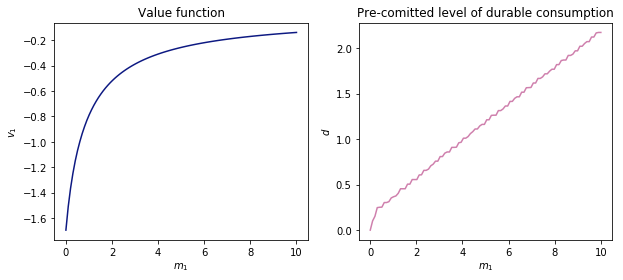

In [64]:
fig = plt.figure(figsize=(10,4))
ax_left = fig.add_subplot(1,2,1)
ax_left.plot(m1_vec,v1_vec, c='#0d1982')
ax_left.set_xlabel(r'$m_1$')
ax_left.set_ylabel(r'$v_1$')
ax_left.set_title('Value function')

ax_right = fig.add_subplot(1,2,2)
ax_right.plot(m1_vec,d1_vec, c='#cf80ad')
ax_right.set_xlabel(r'$m_1$')
ax_right.set_ylabel(r'$d$')
ax_right.set_title('Pre-comitted level of durable consumption')

The left plot shows that the value of cash-on-hand in period 1 is concave. The value function depends positively on m1. However, it appears that the marginal product of m1 is diminishing. 

The right plot shows how pre-comitted durable consumption depends positively on cash on hand. Throughout the values of m1, the slope remains constant, except in cases with very low values of m1.

Next, consider an **extension** of the model, where there is also a **period 0**. In this period, the household makes a choice whether to stick with the level of durables it has, $z = 0$, or adjust its stock of durables, $z = 1$. If adjusting, the household loses a part of the value of its durable stock; more specificaly it incurs a proportional loss of $\Lambda \in (0,1)$.

Mathematically, the **household problem in period 0** is:

$$
\begin{aligned}
v_{0}(m_{0},d_{0}) &= \max_{z\in\{0,1\}} \begin{cases}
w(m_{0},d_{0}) & \text{if } z = 0\\
v_1(m_0+(1-\Lambda) d_{0}) & \text{if } z = 1\\
\end{cases}\\
\end{aligned}
$$

The **parameters** and **grids** for $m_0$ and $d_0$ should be:

In [50]:
Lambda = 0.2
m0_vec = np.linspace(1e-8,6,100)
d0_vec = np.linspace(1e-8,3,100)
ldm_vec = m0_vec + (1-Lambda)*d0_vec

In [51]:
v2_interp2 = interpolate.RegularGridInterpolator((m0_vec,d0_vec), v2_vec, bounds_error=False,fill_value=None)

**Question 3:** For which values of $m_0$ and  $d_0$ is the optimal choice not to adjust, i.e. $z = 0$? Show this in a plot. Give an interpretion of your results.

In [52]:
def v1_alt(d,ldm,alpha,rho,beta,r,Delta,v2_interp):
    #a. low income
    m2_low=(1+r)*(ldm-d)+(1-Delta)
    v2_low=v2_interp([m2_low,d])[0]
    
    #b. middle income
    m2_mid=(1+r)*(ldm-d)+1
    v2_mid=v2_interp([m2_mid,d])[0]
    
    #c. high income
    m2_high=(1+r)*(ldm-d)+(1+Delta)
    v2_high=v2_interp([m2_high,d])[0]
    
    #d. expected v2 value
    v0=1/3*v2_low + 1/3*v2_mid + 1/3*v2_high

In [56]:
def solve_p0(beta,r,Delta,v2_interp):
    # a. grids
    ldm_vec = m0_vec + (1-Lambda)*d0_vec
    v11_vec = np.empty(100)
    d11_vec = np.empty(100)
    
    # b. solve for each m1 in grid
    for i,ldm in enumerate(ldm_vec):
        
        # i. objective
        obj = lambda d: -v1_alt(d,ldm,alpha,rho,beta,r,Delta,v2_interp)
        
        # ii. initial guess
        x0 = ldm*1/2
        
        # iii. bounds and constraitns
        #ineq_con = {'type': 'ineq', 'fun': lambda x: m1-x[0]} 
        
        # iv. optimize
        result = optimize.minimize_scalar(obj,x0, method='bounded', bounds=[1e-4,ldm])
        
        #result = optimize.minimize(obj,x0, method='Nelder-Mead')
        
        # v. save
        v11_vec[i] = -result.fun
        d11_vec[i] = result.x
     
    return ldm_vec,v11_vec,d11_vec

ldm_vec, v11_vec, d11_vec = solve_p0(beta,r,Delta,v2_interp)

ValueError: The lower bound exceeds the upper bound.

In [41]:
#solve period 0
def solve_p0(alpha,chi,rho):

    #a. grids
    
    
    #b. solve for each m2 in grid
    for i,m0 in enumerate(m0_vec):
        for j,d0 in enumerate(d0_vec):
        
        #i. objective
            obj=lambda c: -v2(c,m2,d,alpha,chi,rho)
        
        #ii. initial guess
            x0=m2/2
        
        #iii. optimizer
            result = optimize.minimize_scalar(obj,x0,method='bounded',bounds=[1e-8,m2])
        
            v2_vec[i,j] = -result.fun
            c_vec[i,j] = result.x
            x_vec[i,j] = m2 - result.x
        
    return m2_vec, d_vec, v2_vec, c_vec, x_vec
    


m2_vec, d_vec, v2_vec, c_vec, x_vec = solve_p2(alpha,chi,rho)



# Gradient descent

Let $\boldsymbol{x} = \left[\begin{array}{c}
x_1 \\
x_2\\
\end{array}\right]$ be a two-dimensional vector. Consider the following algorithm:

**Algorithm:** `gradient_descent()`

**Goal:** Minimize the function $f(\boldsymbol{x})$.

1. Choose a tolerance $\epsilon>0$, a scale factor $ \Theta > 0$, and a small number $\Delta > 0$
2. Guess on $\boldsymbol{x}_0$ and set $n=1$
3. Compute a numerical approximation of the jacobian for $f$ by

    $$
    \nabla f(\boldsymbol{x}_{n-1}) \approx \frac{1}{\Delta}\left[\begin{array}{c}
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    \Delta\\
    0
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})\\
    f\left(\boldsymbol{x}_{n-1}+\left[\begin{array}{c}
    0\\
    \Delta
    \end{array}\right]\right)-f(\boldsymbol{x}_{n-1})
    \end{array}\right]
    $$

4. Stop if the maximum element in $|\nabla f(\boldsymbol{x}_{n-1})|$ is less than $\epsilon$
5. Set $\theta = \Theta$ 
6. Compute $f^{\theta}_{n} = f(\boldsymbol{x}_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1}))$
7. If $f^{\theta}_{n} < f(\boldsymbol{x}_{n-1})$ continue to step 9
8. Set $\theta = \frac{\theta}{2}$ and return to step 6     
9. Set $x_{n} = x_{n-1} - \theta \nabla f(\boldsymbol{x}_{n-1})$
10. Set $n = n + 1$ and return to step 3

**Question:** Implement the algorithm above such that the code below can run.

Note that the code in this question is based on code from lecture 11, section 2

**Optimizer function:**

In [67]:
def gradient_descent(f,x0,epsilon=1e-6,Theta=0.1,Delta=1e-8,max_iter=10000):
    """
    Args:
        f (callable)   : function
        x0 (float)     : initial value
        max_iter (int) : maximum 
        
    Returns:
        x (float)      : root
        n (int)        : number of iterators used
    """
    # step 2: initialize
    x = x0
    fx = f(x0)
    n = 1
    
    while n < max_iter:
        
        x_prev = x
        fx_prev = fx
        
        #step 3: compute the jacobian gradiant
        jacx = (1/Delta)*(np.array([f(x_prev+np.array([Delta, 0]))-f(x_prev),f(x_prev+np.array([0, Delta]))-f(x_prev)]))
        
        #step 4: stopping if jacobian is lower than tolerance
        if max(abs(jacx)) < (1e-6):
            break
        else:
            pass
        
        #step 5: define theta
        theta = Theta
        
        #step 6: define ftheta
        ftheta = f(x_prev-theta*jacx)
        
        #step 7: moving on?
        
        #step 8: redefining theta for ftheta >= f(x_prev)
        while ftheta >= f(x_prev):
            theta = theta/2
            
            ftheta = f(x_prev - theta*jacx)
            
            
        #step 9: new guess
        x = x_prev - theta*jacx
            
        #step 10: new iteration
        n += 1
        
    return x,n


**Test case:**

In [26]:
def rosen(x):
    return (1.0-x[0])**2+2*(x[1]-x[0]**2)**2

x0 = np.array([1.1,1.1])
try:
    x,it = gradient_descent(rosen,x0)
    print(f'minimum found at ({x[0]:.4f},{x[1]:.4f}) after {it} iterations')
    assert np.allclose(x,[1,1])
except:
    print('not implemented yet')

minimum found at (1.0000,1.0000) after 306 iterations
